In [29]:
from ortools.sat.python import cp_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [181]:
def read_nurses_data(filepath):
    nurse_df = pd.read_csv(filepath)
    return nurse_df

In [182]:
nurse_filepath = 'data/Nurses.csv'
nurse_df = read_nurses_data(nurse_filepath)
nurse_df

,Nurse,Team
0,0,A
1,1,A
2,2,B
3,3,B
4,4,B
5,5,C
6,6,C
7,7,D
8,8,D
9,9,E


In [183]:
#Create the data
def create_nurse_variables(df, n_days):
    """Creates variables for downstream scheduling functions"""
    num_days = n_days
    num_nurses = len(df['Nurse'])
    num_shifts = 3
    all_nurses = range(num_nurses)
    all_shifts = range(num_shifts)
    all_days = range(num_days)

    return num_nurses, num_shifts, num_days, all_nurses, all_shifts, all_days

In [184]:
n_day = 56
num_nurses, num_shifts, num_days, all_nurses, all_shifts, all_days = create_nurse_variables(nurse_df, n_day)
print(f"All Nurses: {all_nurses}")
print(f"All Shifts: {all_shifts}")
print(f"All days: {all_days}")

All Nurses: range(0, 10)
All Shifts: range(0, 3)
All days: range(0, 56)


In [185]:
def print_team_info():
    teams = nurse_df['Team'].unique()
    print(f"Number of teams: {len(teams)}")
    for team in teams:
        team_size = len(nurse_df[nurse_df['Team'] == team])
        print(f"Team {team}: {team_size} nurses")

In [186]:
print_team_info()

Number of teams: 5
Team A: 2 nurses
Team B: 3 nurses
Team C: 2 nurses
Team D: 2 nurses
Team E: 1 nurses


In [187]:
def initialize_problem(all_nurses, all_shifts, all_days):
    """Initializes the scheduling problem."""
    model = cp_model.CpModel()
    shifts = {}
    for d in all_days:
        for n in all_nurses:
            for s in all_shifts:
                shifts[(n, d, s)] = model.NewBoolVar(f'shift_n{n}d{d}s{s}')
    return model, shifts

In [188]:
model, shifts = initialize_problem(all_nurses, all_shifts, all_days)

In [189]:
def add_basic_constraints():
    """Adds basic constraints to the model."""
    assign_one_nurse_per_shift()
    limit_one_shift_per_day()
    distribute_shifts_evenly()

def assign_one_nurse_per_shift():
    """Ensures each shift is assigned to exactly one nurse."""
    for d in all_days:
        for s in all_shifts:
            model.Add(sum(shifts[(n, d, s)] for n in all_nurses) == 1)

def limit_one_shift_per_day():
    """Limits each nurse to at most one shift per day."""
    for d in all_days:
        for n in all_nurses:
            model.Add(sum(shifts[(n, d, s)] for s in all_shifts) <= 1)

def distribute_shifts_evenly():
    """Distributes shifts evenly among nurses."""
    min_shifts_per_nurse = (num_shifts * num_days) // num_nurses
    max_shifts_per_nurse = min_shifts_per_nurse + 1
    for n in all_nurses:
        num_shifts_worked = sum(shifts[(n, d, s)] for d in all_days for s in all_shifts)
        model.Add(num_shifts_worked >= min_shifts_per_nurse)
        model.Add(num_shifts_worked <= max_shifts_per_nurse)

def distribute_weekend_shifts_evenly():
    """Distributes weekend shifts evenly among nurses."""
    weekend_days = [d for d in all_days if d % 7 in [5, 6]]
    min_weekend_shifts = (len(weekend_days) * num_shifts) // num_nurses
    max_weekend_shifts = min_weekend_shifts + 1
    for n in all_nurses:
        weekend_shifts = sum(shifts[(n, d, s)] for d in weekend_days for s in all_shifts)
        model.Add(weekend_shifts >= min_weekend_shifts)
        model.Add(weekend_shifts <= max_weekend_shifts)

def prevent_consecutive_shifts(shift_set):
    """Prevents nurses from working consecutive days for specified shifts."""
    for n in all_nurses:
        for d in range(num_days - 1):
            model.Add(sum(shifts[(n, d, s)] for s in shift_set) + 
                    sum(shifts[(n, d + 1, s)] for s in shift_set) <= 1)

def enforce_consecutive_days_for_shift(shift, days):
    """Enforces consecutive days for a specific shift."""
    for week in range(num_days // 7):
        start_day = week * 7
        for n in all_nurses:
            for d in range(len(days) - 1):
                model.Add(shifts[(n, start_day + days[d], shift)] == 
                        shifts[(n, start_day + days[d+1], shift)])

def limit_shifts_per_week(max_shifts):
    """Limits the number of shifts a nurse can work per week."""
    for week in range(num_days // 7):
        for n in all_nurses:
            week_shifts = sum(shifts[(n, d, s)] for d in range(week * 7, (week + 1) * 7) 
                            for s in all_shifts)
            model.Add(week_shifts <= max_shifts)

def restrict_shift_for_team(team, shift):
    """Prevents nurses from a specific team from working a particular shift."""
    team_nurses = nurse_df[nurse_df['Team'] == team]['Nurse'].tolist()
    for n in team_nurses:
        for d in all_days:
            model.Add(shifts[(n, d, shift)] == 0)

def limit_nurses_per_team_per_day(max_nurses):
    """Limits the number of nurses from each team working on any given day."""
    teams = nurse_df['Team'].unique()
    for team in teams:
        team_nurses = nurse_df[nurse_df['Team'] == team]['Nurse'].tolist()
        for d in all_days:
            model.Add(sum(shifts[(n, d, s)] for n in team_nurses 
                        for s in all_shifts) <= max_nurses)

def balance_shift_types():
    """Create variables to measure the imbalance in shift types."""
    target_shifts_per_type = num_days // num_shifts
    imbalance = {}
    for n in all_nurses:
        for s in all_shifts:
            num_shifts_of_type = sum(shifts[(n, d, s)] for d in all_days)
            imbalance[(n, s)] = model.NewIntVar(0, num_days, f'imbalance_n{n}_s{s}')
            model.Add(imbalance[(n, s)] >= num_shifts_of_type - target_shifts_per_type)
            model.Add(imbalance[(n, s)] >= target_shifts_per_type - num_shifts_of_type)
    
    total_imbalance = model.NewIntVar(0, num_nurses * num_shifts * num_days, 'total_imbalance')
    model.Add(total_imbalance == sum(imbalance.values()))
    return total_imbalance

def ensure_minimum_rest_period():
    """Count violations of minimum rest period between shifts, especially after night shifts."""
    night_shift = 2  # Assuming shift 2 is the night shift
    min_rest_days = 2
    rest_violations = []
    for n in all_nurses:
        for d in range(num_days - min_rest_days):
            # Check if nurse works a night shift followed by any shift within min_rest_days
            violation = model.NewBoolVar(f'rest_violation_n{n}_d{d}')
            night_shift_worked = shifts[(n, d, night_shift)]
            subsequent_shifts = [shifts[(n, d+i, s)] for i in range(1, min_rest_days+1) for s in all_shifts]
            model.Add(sum([night_shift_worked] + subsequent_shifts) <= 1).OnlyEnforceIf(violation.Not())
            model.Add(sum([night_shift_worked] + subsequent_shifts) > 1).OnlyEnforceIf(violation)
            rest_violations.append(violation)
    
    total_violations = model.NewIntVar(0, len(rest_violations), 'total_rest_violations')
    model.Add(total_violations == sum(rest_violations))
    return total_violations

def limit_night_shifts():
    """Encourage limiting the number of night shifts a nurse can work in a given period."""
    night_shift = 2  # Assuming shift 2 is the night shift
    target_night_shifts = num_days // (2 * num_nurses)  # This was previously the maximum
    night_shift_violations = []
    for n in all_nurses:
        nurse_night_shifts = sum(shifts[(n, d, night_shift)] for d in all_days)
        violation = model.NewIntVar(0, num_days, f'night_shift_violation_n{n}')
        model.Add(violation >= nurse_night_shifts - target_night_shifts)
        night_shift_violations.append(violation)
    
    total_violations = model.NewIntVar(0, num_nurses * num_days, 'total_night_shift_violations')
    model.Add(total_violations == sum(night_shift_violations))
    return total_violations

def ensure_skill_mix():
    """Encourage a mix of nurses from different teams across shifts using soft constraints."""
    teams = nurse_df['Team'].unique()
    
    # Create a variable to count the number of shifts with good team mix
    good_mix_count = model.NewIntVar(0, num_days * num_shifts, 'good_mix_count')
    
    mix_indicators = []
    for d in all_days:
        for s in all_shifts:
            team_represented = []
            for team in teams:
                team_nurses = nurse_df[nurse_df['Team'] == team]['Nurse'].tolist()
                team_working = model.NewBoolVar(f'team_{team}_working_d{d}_s{s}')
                model.Add(sum(shifts[(n, d, s)] for n in team_nurses) >= 1).OnlyEnforceIf(team_working)
                model.Add(sum(shifts[(n, d, s)] for n in team_nurses) == 0).OnlyEnforceIf(team_working.Not())
                team_represented.append(team_working)
            
            # Indicator for good mix (at least 2 teams represented)
            good_mix = model.NewBoolVar(f'good_mix_d{d}_s{s}')
            model.Add(sum(team_represented) >= 2).OnlyEnforceIf(good_mix)
            model.Add(sum(team_represented) < 2).OnlyEnforceIf(good_mix.Not())
            mix_indicators.append(good_mix)
    
    # Set the good_mix_count to the number of shifts with good mix
    model.Add(good_mix_count == sum(mix_indicators))
    
    # Maximize the number of shifts with good mix
    model.Maximize(good_mix_count)

In [190]:
def solve_model():
    """Solves the constraint satisfaction problem."""
    solver = cp_model.CpSolver()
    status = solver.Solve(model)
    return solver, status

def get_solution(solver):
    """Retrieves the solution if one exists."""
    if solver.StatusName() == 'OPTIMAL':
        rota_dict = {(n, d, s) for (n, d, s) in shifts if solver.Value(shifts[(n, d, s)]) == 1}
        solution = pd.DataFrame(rota_dict, columns=['Nurse', 'Day', 'Shift']).sort_values(by=['Day'])
        rota = solution.pivot(index='Day', columns='Shift', values='Nurse')
        return rota
    else:
        return None


def summarize_shifts(solver):
    """Summarizes the total, weekend, and type-specific shifts for each nurse."""
    total_shifts = {n: 0 for n in all_nurses}
    weekend_shifts = {n: 0 for n in all_nurses}
    shift_types = {n: {s: 0 for s in all_shifts} for n in all_nurses}
    
    for n in all_nurses:
        for d in all_days:
            for s in all_shifts:
                if solver.Value(shifts[(n, d, s)]) == 1:
                    total_shifts[n] += 1
                    shift_types[n][s] += 1
                    if d % 7 in [5, 6]:
                        weekend_shifts[n] += 1
    
    summary = pd.DataFrame({
        'Nurse': all_nurses,
        'Total Shifts': [total_shifts[n] for n in all_nurses],
        'Weekend Shifts': [weekend_shifts[n] for n in all_nurses],
        'ED Day 1 Shifts': [shift_types[n][0] for n in all_nurses],
        'ED Day 2 Shifts': [shift_types[n][1] for n in all_nurses],
        'ED Night Shifts': [shift_types[n][2] for n in all_nurses]
    })
    return summary

In [191]:
def plot_shift_summary(summary):
    """Plot a bar chart of total and weekend shifts for each nurse."""
    plt.figure(figsize=(12, 6))
    summary.plot(x='Nurse', y=['Total Shifts', 'Weekend Shifts'], kind='bar')
    plt.title('Shift Distribution Among Nurses')
    plt.xlabel('Nurse')
    plt.ylabel('Number of Shifts')
    plt.legend(title='Shift Type')
    plt.tight_layout()
    plt.show()

def plot_schedule_heatmap(rota):
    """Plot a heatmap of the nurse schedule."""
    plt.figure(figsize=(20, 10))
    sns.heatmap(rota, cmap='YlGnBu', cbar_kws={'label': 'Nurse'})
    plt.title('Nurse Schedule Heatmap')
    plt.xlabel('Shift')
    plt.ylabel('Day')
    plt.tight_layout()
    plt.show()


def generate_fairness_report(summary):
    """Generate a report on the fairness of shift distribution."""
    fairness_report = {
        'Total Shifts': summary['Total Shifts'].agg(['mean', 'std', 'min', 'max']).to_dict(),
        'Weekend Shifts': summary['Weekend Shifts'].agg(['mean', 'std', 'min', 'max']).to_dict(),
        'ED Day 1 Shifts': summary['ED Day 1 Shifts'].agg(['mean', 'std', 'min', 'max']).to_dict(),
        'ED Day 2 Shifts': summary['ED Day 2 Shifts'].agg(['mean', 'std', 'min', 'max']).to_dict(),
        'ED Night Shifts': summary['ED Night Shifts'].agg(['mean', 'std', 'min', 'max']).to_dict(),
    }
    return pd.DataFrame(fairness_report)

def generate_work_pattern_report(rota):
    """Generate a report on work patterns."""
    consecutive_shifts = []
    for nurse in rota.columns:
        shift_count = 0
        for day in rota.index:
            if pd.notna(rota.loc[day, nurse]) and rota.loc[day, nurse] != -1:
                shift_count += 1
            else:
                if shift_count > 1:
                    consecutive_shifts.append(shift_count)
                shift_count = 0
        if shift_count > 1:
            consecutive_shifts.append(shift_count)
    
    work_pattern_report = {
        'Metric': ['Mean Consecutive Shifts', 'Max Consecutive Shifts', 'Min Consecutive Shifts',
                'No more than 4 shifts/week', 'Mon-Wed night shift pattern', 
                'Minimum rest period', 'Maximum night shifts'],
        'Value': [f"{np.mean(consecutive_shifts):.2f}" if consecutive_shifts else "N/A", 
                f"{max(consecutive_shifts)}" if consecutive_shifts else "N/A", 
                f"{min(consecutive_shifts)}" if consecutive_shifts else "N/A",
                'Enforced by constraint', 
                'Enforced by constraint',
                'Enforced by constraint', 
                'Enforced by constraint']
    }
    return pd.DataFrame(work_pattern_report)

def generate_team_depletion_report(summary, nurse_df):
    """Generate a report on team depletion avoidance and shift distribution among teams."""
    # Merge on 'Nurse' column
    team_summary = summary.merge(nurse_df, on='Nurse')
    
    # Calculate total shifts per team
    team_shifts = team_summary.groupby('Team').agg({
        'Total Shifts': ['sum', 'mean', 'std', 'min', 'max'],
        'ED Day 1 Shifts': ['sum', 'mean'],
        'ED Day 2 Shifts': ['sum', 'mean'],
        'ED Night Shifts': ['sum', 'mean']
    }).reset_index()
    
    # Flatten column names
    team_shifts.columns = ['_'.join(col).strip() for col in team_shifts.columns.values]
    team_shifts.rename(columns={'Team_': 'Team'}, inplace=True)

    team_shifts = team_shifts.replace({np.nan: 0.00})
    
    team_shifts['Compliance'] = 'Max 1 nurse per team per day (enforced by constraint)'
    
    # Calculate average number of nurses working per team per day
    total_days = summary['Total Shifts'].sum() // len(summary)  # Assuming all nurses work every day
    avg_nurses_per_team = team_summary.groupby('Team')['Total Shifts'].sum() / total_days
    
    skill_mix_report = pd.DataFrame({
        'Metric': ['Average number of nurses working per team per day'],
        'Value': [f"{avg_nurses_per_team.mean():.2f}"]
    })
    
    return team_shifts, skill_mix_report

def calculate_avg_teams_per_shift(summary, nurse_df, num_shifts):
    team_summary = summary.merge(nurse_df[['Nurse', 'Team']], left_index=True, right_on='Nurse')
    total_teams_represented = 0
    for shift_type in ['ED Day 1 Shifts', 'ED Day 2 Shifts', 'ED Night Shifts']:
        teams_represented = (team_summary[shift_type] > 0).groupby(team_summary['Team']).any().sum()
        total_teams_represented += teams_represented
    avg_teams_per_shift = total_teams_represented / (3 * num_shifts)  # 3 shift types
    return avg_teams_per_shift

def plot_shift_type_distribution(summary):
    """Plot a stacked bar chart of shift type distribution for each nurse."""
    shift_types = ['ED Day 1 Shifts', 'ED Day 2 Shifts', 'ED Night Shifts']
    plt.figure(figsize=(15, 8))
    summary[shift_types].plot(kind='bar', stacked=True)
    plt.title('Distribution of Shift Types Among Nurses')
    plt.xlabel('Nurse')
    plt.ylabel('Number of Shifts')
    plt.legend(title='Shift Type')
    plt.tight_layout()
    plt.show()

Adding basic constraints...
Solving model...
Distributing shifts evenly...
Solving model...
Distributing weekend shifts evenly...
Solving model...
Preventing consecutive shifts...
Solving model...
Enforcing consecutive days for night shift...
Solving model...
Limiting shifts per week...
Solving model...
Restricting shift for team A...
Solving model...
Limiting nurses per team per day...
Solving model...
Ensuring skill mix...
Solving model...
Adding optimization objectives...
Solving model with optimization objectives...

Final Rota:


Shift,0,1,2
Day,,,
0,2,6,1
1,4,9,1
2,3,5,1
3,8,9,4
4,5,7,3
5,8,6,2
6,5,7,4
7,8,6,1
8,3,5,1



Final Shift Summary:


,Nurse,Total Shifts,Weekend Shifts,ED Day 1 Shifts,ED Day 2 Shifts,ED Night Shifts
0,0,17,5,0,5,12
1,1,17,4,0,4,13
2,2,16,5,7,4,5
3,3,17,5,7,5,5
4,4,17,5,2,7,8
5,5,17,5,6,9,2
6,6,17,5,9,6,2
7,7,17,5,7,8,2
8,8,16,4,8,4,4
9,9,17,5,10,4,3



Shift type imbalance: 372
Rest period violations: 23
Night shift violations: 36

Fairness Report:


,Total Shifts,Weekend Shifts,ED Day 1 Shifts,ED Day 2 Shifts,ED Night Shifts
mean,16.800000,4.800000,5.600000,5.600000,5.600000
std,0.421637,0.421637,3.627059,1.837873,4.087923
min,16.000000,4.000000,0.000000,4.000000,2.000000
max,17.000000,5.000000,10.000000,9.000000,13.000000



Work Pattern Report:


,Metric,Value
0,Mean Consecutive Shifts,56.00
1,Max Consecutive Shifts,56
2,Min Consecutive Shifts,56
3,No more than 4 shifts/week,Enforced by constraint
4,Mon-Wed night shift pattern,Enforced by constraint
5,Minimum rest period,Enforced by constraint
6,Maximum night shifts,Enforced by constraint



Team Depletion Report:
Team Shifts:


,Team,Total Shifts_sum,Total Shifts_mean,Total Shifts_std,Total Shifts_min,Total Shifts_max,ED Day 1 Shifts_sum,ED Day 1 Shifts_mean,ED Day 2 Shifts_sum,ED Day 2 Shifts_mean,ED Night Shifts_sum,ED Night Shifts_mean,Compliance
0,A,34,17.000000,0.000000,17,17,0,0.000000,9,4.500000,25,12.5,Max 1 nurse per team per day (enforced by cons...
1,B,50,16.666667,0.577350,16,17,16,5.333333,16,5.333333,18,6.0,Max 1 nurse per team per day (enforced by cons...
2,C,34,17.000000,0.000000,17,17,15,7.500000,15,7.500000,4,2.0,Max 1 nurse per team per day (enforced by cons...
3,D,33,16.500000,0.707107,16,17,15,7.500000,12,6.000000,6,3.0,Max 1 nurse per team per day (enforced by cons...
4,E,17,17.000000,0.000000,17,17,10,10.000000,4,4.000000,3,3.0,Max 1 nurse per team per day (enforced by cons...



Skill Mix Report:


,Metric,Value
0,Average number of nurses working per team per day,2.10



Average number of teams represented per shift: 1.56


<Figure size 1200x600 with 0 Axes>

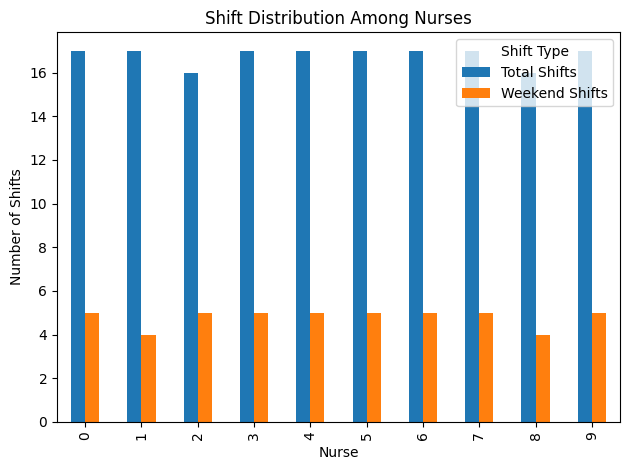

<Figure size 1500x800 with 0 Axes>

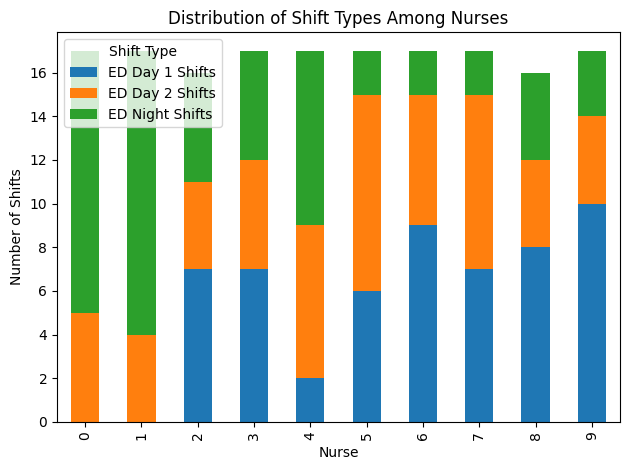

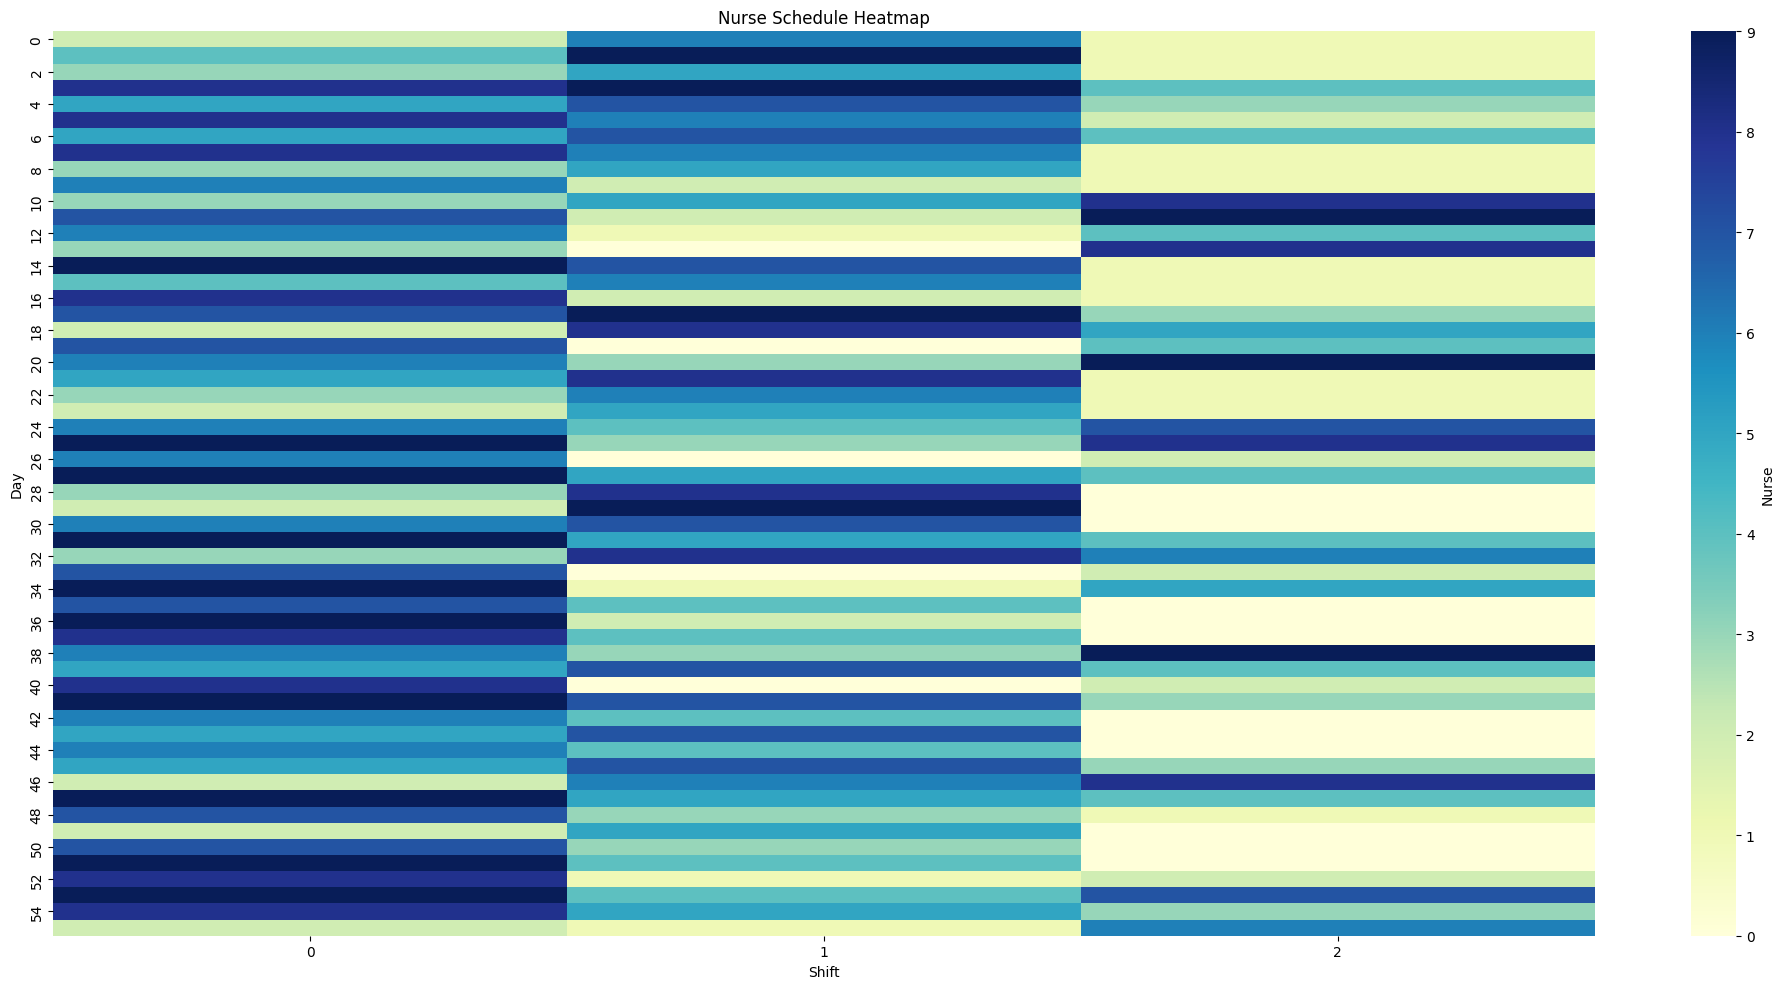

In [192]:
if __name__ == "__main__":

    constraints = [
        ("Adding basic constraints...", add_basic_constraints),
        ("Distributing shifts evenly...", distribute_shifts_evenly),
        ("Distributing weekend shifts evenly...", distribute_weekend_shifts_evenly),
        ("Preventing consecutive shifts...", lambda: prevent_consecutive_shifts([0, 1])),
        ("Enforcing consecutive days for night shift...", lambda: enforce_consecutive_days_for_shift(2, [0, 1, 2])),
        ("Limiting shifts per week...", lambda: limit_shifts_per_week(4)),
        ("Restricting shift for team A...", lambda: restrict_shift_for_team('A', 0)),
        ("Limiting nurses per team per day...", lambda: limit_nurses_per_team_per_day(1)),
        ("Ensuring skill mix...", ensure_skill_mix),
    ]

    for i, (message, constraint_func) in enumerate(constraints):
        print(message)
        constraint_func()
        
        print("Solving model...")
        solver = cp_model.CpSolver()
        solver.parameters.max_time_in_seconds = 180.0  # 3 minutes
        status = solver.Solve(model)
        

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        print("Adding optimization objectives...")
        shift_imbalance = balance_shift_types()
        rest_violations = ensure_minimum_rest_period()
        night_shift_violations = limit_night_shifts()

        # Combine objectives with weights
        model.Minimize(shift_imbalance + 10 * rest_violations + 5 * night_shift_violations)

        print("Solving model with optimization objectives...")
        solver = cp_model.CpSolver()
        solver.parameters.max_time_in_seconds = 600.0  # 10 minutes for final optimization
        status = solver.Solve(model)

        if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
            rota = get_solution(solver)
            summary = summarize_shifts(solver)
            print("\nFinal Rota:")
            display(rota)
            print("\nFinal Shift Summary:")
            display(summary)
            print(f"\nShift type imbalance: {solver.Value(shift_imbalance)}")
            print(f"Rest period violations: {solver.Value(rest_violations)}")
            print(f"Night shift violations: {solver.Value(night_shift_violations)}")

            # Generate reports
            print("\nFairness Report:")
            fairness_report = generate_fairness_report(summary)
            display(fairness_report)

            print("\nWork Pattern Report:")
            work_pattern_report = generate_work_pattern_report(rota)
            display(work_pattern_report)

            print("\nTeam Depletion Report:")
            team_shifts, skill_mix_report = generate_team_depletion_report(summary, nurse_df)
            print("Team Shifts:")
            display(team_shifts)
            print("\nSkill Mix Report:")
            display(skill_mix_report)

            # Calculate and display average teams per shift
            avg_teams_per_shift = calculate_avg_teams_per_shift(summary, nurse_df, num_shifts)
            print(f"\nAverage number of teams represented per shift: {avg_teams_per_shift:.2f}")


            # Generate plots
            plot_shift_summary(summary)
            plot_shift_type_distribution(summary)
            plot_schedule_heatmap(rota)

        else:
            print("Failed to optimize objectives.")
            print(f'Solver status: {solver.StatusName()}')
    else:
        print("Failed to find a feasible solution.")

In [204]:
import pandas as pd
from IPython.display import display, HTML

def create_nurse_schedule(rota, nurse_df, nurse_id):
    # Creates schedule for 56 days
    num_days = 56
    schedule = pd.DataFrame({
        'Day': range(num_days),
        'DOW': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'] * 8,
        'Description': [''] * num_days,
        'Hours': [''] * num_days
    })

    # Fills in the schedule based on rota
    shift_map = {0: 'ED Day 1', 1: 'ED Day 2', 2: 'ED Nights'}
    hours_map = {'ED Day 1': '8am-9pm', 'ED Day 2': '10am-8pm', 'ED Nights': '8pm-9am'}
    color_map = {'ED Day 1': 'red', 'ED Day 2': 'blue', 'ED Nights': 'green', 'Rest Day': 'grey'}

    for day in range(num_days):
        for shift in range(3):
            if rota.loc[day, shift] == nurse_id:
                schedule.loc[day, 'Description'] = shift_map[shift]
                schedule.loc[day, 'Hours'] = hours_map[shift_map[shift]]

    schedule.loc[schedule['Description'] == '', 'Description'] = 'Rest Day'

    # Stylizes the schedule DataFrame
    def style_row(row):
        color = color_map[row['Description']]
        return [f'color: {color}'] * len(row)

    styled = schedule.style.apply(style_row, axis=1)
    styled = styled.set_properties(**{'text-align': 'center'})
    styled = styled.set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('color', 'white'), ('background-color', 'black')]},
        {'selector': 'td', 'props': [('background-color', '#000000')]},
    ])

    # Adds dynamic title that changes the nurse id and team
    team = nurse_df.loc[nurse_df['Nurse'] == nurse_id, 'Team'].values[0]
    title = f"Nurse {nurse_id} Schedule - Team {team}"
    
    return title, styled

title, styled_schedule = create_nurse_schedule(rota, nurse_df, 9)

# Display the schedule
display(HTML(f"<h2 style='color: white;'>{title}</h2>"))
display(styled_schedule)

,Day,DOW,Description,Hours
0,0,Mon,Rest Day,
1,1,Tue,ED Day 2,10am-8pm
2,2,Wed,Rest Day,
3,3,Thu,ED Day 2,10am-8pm
4,4,Fri,Rest Day,
5,5,Sat,Rest Day,
6,6,Sun,Rest Day,
7,7,Mon,Rest Day,
8,8,Tue,Rest Day,
9,9,Wed,Rest Day,
